# 📘 2D Surface Fitting: Gaussian Beam Profile Analysis

> Fit 2D Gaussian surfaces to beam profile data and extract spatial parameters

⏱️ **15-25 minutes** | 📊 **Level: ●●○ Intermediate** | 🏷️ **Physics** | 🔬 **Optics/Imaging**

---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/imewei/NLSQ/blob/main/examples/notebooks/04_gallery/physics/surface_fitting_2d.ipynb)

In [1]:
# @title Install NLSQ (run once in Colab)
import sys

if 'google.colab' in sys.modules:
    print("Running in Google Colab - installing NLSQ...")
    !pip install -q nlsq
    print("✅ NLSQ installed successfully!")
else:
    print("Not running in Colab - assuming NLSQ is already installed")

Not running in Colab - assuming NLSQ is already installed


## 🔬 Domain Background

**Physical System:** 2D Gaussian intensity distribution (laser beam profile, microscopy PSF)

**Model Equation:**
$$z(x,y) = A \exp\left(-\frac{(x-x_0)^2}{2\sigma_x^2} - \frac{(y-y_0)^2}{2\sigma_y^2}\right) + z_0$$

**Where:**
- $A$: Peak amplitude (intensity above background)
- $(x_0, y_0)$: Center coordinates
- $\sigma_x, \sigma_y$: Standard deviations (beam widths) in x and y directions
- $z_0$: Background offset (baseline)

**Common applications:**
- **Laser beam profiling** - Characterizing beam shape and quality (M² measurements)
- **Microscopy PSF** - Point spread function characterization for deconvolution
- **AFM/STM topography** - Fitting surface features and peaks
- **Astronomical imaging** - Source extraction and photometry
- **Particle detection** - Blob detection in images

**Why 2D fitting matters:**
Many physical systems produce 2D intensity distributions that need quantitative characterization. Extracting center position, widths, and ellipticity provides critical information for optical alignment, image analysis, and quality control.

---

## 🎯 What You'll Learn

After this tutorial, you will be able to:

- ✓ **Set up 2D fitting** with NLSQ using multi-dimensional xdata
- ✓ **Define 2D model functions** for surface fitting
- ✓ **Extract spatial parameters** (center, widths, ellipticity)
- ✓ **Calculate derived quantities** like FWHM and beam area
- ✓ **Visualize 2D fits** with cross-sections and residual maps
- ✓ **Apply weighted fitting** with 2D uncertainty arrays

---

## 📊 Parameter Interpretation Guide

| Parameter | Physical Meaning | Typical Range | What Affects It |
|-----------|-----------------|---------------|-----------------|
| $A$ | Peak intensity above background | 100-10000 counts | Source brightness, exposure time |
| $x_0, y_0$ | Beam center position | Within FOV | Alignment, beam pointing |
| $\sigma_x, \sigma_y$ | Beam widths (1/e² radius) | 0.1-10 mm | Focusing, aberrations |
| $z_0$ | Background level | 0-1000 counts | Dark current, stray light |

**Derived quantities:**
- **FWHM** = 2.355 × σ: Full width at half maximum (common specification)
- **Beam area** = 2π × σ_x × σ_y: Effective beam cross-section
- **Ellipticity** = σ_x / σ_y: Deviation from circular (1.0 = circular)
- **Total intensity** = A × 2π × σ_x × σ_y: Integrated power

**Physical insights from fitted values:**
- **Ellipticity ≠ 1:** Indicates astigmatism or asymmetric aberrations
- **Center offset:** Measures beam pointing or sample position
- **Widths ratio:** Characterizes beam quality and focusing

---

## ⚡ Quick Example

```python
import numpy as np
import jax.numpy as jnp
from nlsq import curve_fit

# Define 2D Gaussian model
def gaussian_2d(xy, amplitude, x0, y0, sigma_x, sigma_y, offset):
    x, y = xy[0], xy[1]
    return amplitude * jnp.exp(
        -((x - x0)**2 / (2*sigma_x**2) + (y - y0)**2 / (2*sigma_y**2))
    ) + offset

# Create 2D grid and flatten
x_1d = np.linspace(-5, 5, 50)
y_1d = np.linspace(-5, 5, 50)
X, Y = np.meshgrid(x_1d, y_1d)
xdata = np.vstack([X.flatten(), Y.flatten()])  # Shape: (2, 2500)

# Fit the model
popt, pcov = curve_fit(
    gaussian_2d,
    xdata,
    z_measured,
    p0=[1000, 0, 0, 1.5, 1.5, 50],
    bounds=([0, -5, -5, 0.1, 0.1, 0], [2000, 5, 5, 10, 10, 200])
)

# Extract results
amplitude, x0, y0, sigma_x, sigma_y, offset = popt
fwhm_x = 2.355 * sigma_x  # FWHM from sigma
```

**Expected results:**
- Center position within ±0.01 mm of true values
- Beam widths recovered with <1% error
- χ²/dof ≈ 1.0 for properly weighted fit

---

## 📖 Setup and Model Definition

First, let's import the necessary modules and define our 2D Gaussian model.

In [2]:
# Configure matplotlib for inline plotting
%matplotlib inline

In [3]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from nlsq import curve_fit

# Set random seed for reproducibility
np.random.seed(42)


def gaussian_2d(xy, amplitude, x0, y0, sigma_x, sigma_y, offset):
    """
    2D Gaussian surface model (elliptical).

    Parameters
    ----------
    xy : ndarray
        Shape (2, n_points) where xy[0] = x coordinates, xy[1] = y coordinates.
    amplitude : float
        Peak amplitude (max height above offset).
    x0, y0 : float
        Center coordinates.
    sigma_x, sigma_y : float
        Standard deviations in x and y directions.
    offset : float
        Background offset (baseline).

    Returns
    -------
    z : ndarray
        Shape (n_points,) with z values at each (x, y) point.
    """
    x = xy[0]
    y = xy[1]
    return (
        amplitude
        * jnp.exp(-((x - x0) ** 2 / (2 * sigma_x**2) + (y - y0) ** 2 / (2 * sigma_y**2)))
        + offset
    )


print("✅ Model functions defined")

✅ Model functions defined


## 1. Generate Synthetic 2D Data

We'll simulate a realistic laser beam profile measurement:
- **Grid:** 50×50 pixels (typical for beam profilers)
- **Beam:** Elliptical Gaussian with slight off-center position
- **Noise:** Poisson-like (realistic for photon counting)

**Key concept:** NLSQ expects 2D data in a specific format:
- `xdata`: Shape `(2, n_points)` where `xdata[0]` = x coordinates, `xdata[1]` = y coordinates
- `ydata`: Shape `(n_points,)` with z values at each (x, y) point

In [4]:
# Create a 2D grid (simulating a camera sensor)
nx, ny = 50, 50  # 50x50 pixel sensor
x_1d = np.linspace(-5, 5, nx)
y_1d = np.linspace(-5, 5, ny)
X, Y = np.meshgrid(x_1d, y_1d)

# Flatten for curve_fit (NLSQ expects flattened 2D data)
x_flat = X.flatten()
y_flat = Y.flatten()
n_points = len(x_flat)

# Stack into shape (2, n_points) for xdata
xdata = np.vstack([x_flat, y_flat])

print("=" * 70)
print("2D SURFACE FITTING: GAUSSIAN BEAM PROFILE ANALYSIS")
print("=" * 70)
print(f"\nGrid: {nx} x {ny} = {n_points} points")
print(f"xdata shape: {xdata.shape}")

2D SURFACE FITTING: GAUSSIAN BEAM PROFILE ANALYSIS

Grid: 50 x 50 = 2500 points
xdata shape: (2, 2500)


In [5]:
# True parameters (simulating a laser beam profile)
amplitude_true = 1000.0  # Peak intensity (counts)
x0_true = 0.5            # Beam center x (slightly off-center)
y0_true = -0.3           # Beam center y
sigma_x_true = 1.5       # Beam width x (mm)
sigma_y_true = 1.2       # Beam width y (elliptical)
offset_true = 50.0       # Background (dark counts)

print("\nTrue Parameters (Laser Beam Profile):")
print(f"  Amplitude: {amplitude_true:.1f} counts")
print(f"  Center:    ({x0_true:.2f}, {y0_true:.2f}) mm")
print(f"  Widths:    sigma_x = {sigma_x_true:.2f}, sigma_y = {sigma_y_true:.2f} mm")
print(f"  Offset:    {offset_true:.1f} counts")

# Generate true surface
z_true = gaussian_2d(xdata, amplitude_true, x0_true, y0_true, sigma_x_true, sigma_y_true, offset_true)

# Add Poisson-like noise (realistic for photon counting)
noise_scale = np.sqrt(z_true + 10)  # Poisson approximation
noise = np.random.normal(0, noise_scale)
z_measured = z_true + noise

# Uncertainties
sigma = noise_scale

print(f"\nData generated with Poisson noise (SNR ~ {amplitude_true / np.mean(noise_scale):.1f})")


True Parameters (Laser Beam Profile):
  Amplitude: 1000.0 counts
  Center:    (0.50, -0.30) mm
  Widths:    sigma_x = 1.50, sigma_y = 1.20 mm
  Offset:    50.0 counts



Data generated with Poisson noise (SNR ~ 86.8)


## 2. Fit the 2D Gaussian Surface

We'll use NLSQ's `curve_fit` with:
- **Initial guess** from data inspection (max, min, center)
- **Physical bounds** to constrain parameters to realistic ranges
- **Measurement uncertainties** (sigma) for weighted fitting

In [6]:
print("\n" + "-" * 70)
print("FITTING 2D GAUSSIAN SURFACE")
print("-" * 70)

# Initial guess (from data inspection)
p0 = [
    z_measured.max() - z_measured.min(),  # amplitude
    0.0,  # x0 (center guess)
    0.0,  # y0
    2.0,  # sigma_x
    2.0,  # sigma_y
    z_measured.min(),  # offset
]

# Parameter bounds (physical constraints)
bounds = (
    [0, -5, -5, 0.1, 0.1, 0],      # Lower: positive amplitude, widths > 0
    [2000, 5, 5, 10, 10, 200],     # Upper: reasonable maxima
)

print("\nInitial guess:")
print(f"  p0 = {p0}")

# Perform the fit
popt, pcov = curve_fit(
    gaussian_2d,
    xdata,
    z_measured,
    p0=p0,
    sigma=sigma,
    bounds=bounds,
    absolute_sigma=True,
)

# Extract fitted parameters
amplitude_fit, x0_fit, y0_fit, sigma_x_fit, sigma_y_fit, offset_fit = popt
perr = np.sqrt(np.diag(pcov))
amp_err, x0_err, y0_err, sx_err, sy_err, off_err = perr

print("\n✅ Fit completed successfully!")
print("\nFitted Parameters:")
print(f"  Amplitude: {amplitude_fit:.1f} +/- {amp_err:.1f} counts (true: {amplitude_true:.1f})")
print(f"  Center x:  {x0_fit:.3f} +/- {x0_err:.3f} mm (true: {x0_true:.2f})")
print(f"  Center y:  {y0_fit:.3f} +/- {y0_err:.3f} mm (true: {y0_true:.2f})")
print(f"  Sigma x:   {sigma_x_fit:.3f} +/- {sx_err:.3f} mm (true: {sigma_x_true:.2f})")
print(f"  Sigma y:   {sigma_y_fit:.3f} +/- {sy_err:.3f} mm (true: {sigma_y_true:.2f})")
print(f"  Offset:    {offset_fit:.1f} +/- {off_err:.1f} counts (true: {offset_true:.1f})")


----------------------------------------------------------------------
FITTING 2D GAUSSIAN SURFACE
----------------------------------------------------------------------


INFO:nlsq.curve_fit:Starting curve fit n_params=6 | n_data_points=2500 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=6 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08



Initial guess:
  p0 = [Array(1043.26116088, dtype=float64), 0.0, 0.0, 2.0, 2.0, Array(25.80215497, dtype=float64)]


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=3.194596s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=7 | final_cost=1203.9727 | elapsed=3.195s | final_gradient_norm=2.8737e-04


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=4.315074s


INFO:nlsq.curve_fit:Curve fit completed total_time=4.3151 | final_cost=2407.9454 | covariance_warning=False



✅ Fit completed successfully!

Fitted Parameters:
  Amplitude: 1002.1 +/- 3.1 counts (true: 1000.0)
  Center x:  0.497 +/- 0.004 mm (true: 0.50)
  Center y:  -0.300 +/- 0.003 mm (true: -0.30)
  Sigma x:   1.505 +/- 0.003 mm (true: 1.50)
  Sigma y:   1.198 +/- 0.003 mm (true: 1.20)
  Offset:    50.1 +/- 0.2 counts (true: 50.0)


## 3. Calculate Derived Beam Properties

From the fitted parameters, we extract physically meaningful quantities:
- **FWHM** (Full Width at Half Maximum) - common beam specification
- **Beam area** - effective cross-sectional area
- **Ellipticity** - deviation from circular beam

In [7]:
# Derived quantities
fwhm_x = 2.355 * sigma_x_fit  # FWHM = 2.355 * sigma
fwhm_y = 2.355 * sigma_y_fit
beam_area = 2 * np.pi * sigma_x_fit * sigma_y_fit  # Beam area
total_intensity = amplitude_fit * beam_area  # Integrated intensity
ellipticity = sigma_x_fit / sigma_y_fit

print("\nDerived Beam Properties:")
print(f"  FWHM x:           {fwhm_x:.3f} mm")
print(f"  FWHM y:           {fwhm_y:.3f} mm")
print(f"  Ellipticity:      {ellipticity:.3f} (1.0 = circular)")
print(f"  Beam area:        {beam_area:.2f} mm²")
print(f"  Total intensity:  {total_intensity:.0f} counts·mm²")


Derived Beam Properties:
  FWHM x:           3.545 mm
  FWHM y:           2.822 mm
  Ellipticity:      1.256 (1.0 = circular)
  Beam area:        11.34 mm²
  Total intensity:  11360 counts·mm²


## 4. Assess Goodness of Fit

We evaluate fit quality using chi-squared statistic:
- **χ²/dof ≈ 1.0** indicates good fit
- **χ²/dof >> 1** suggests poor fit or underestimated uncertainties
- **χ²/dof << 1** suggests overestimated uncertainties

In [8]:
# Goodness of fit
z_fit = gaussian_2d(xdata, *popt)
residuals = z_measured - z_fit
chi_squared = np.sum((residuals / sigma) ** 2)
dof = n_points - len(popt)
chi_squared_reduced = chi_squared / dof

print("\nGoodness of Fit:")
print(f"  χ²/dof = {chi_squared_reduced:.3f} (expect ~1.0)")

if 0.8 < chi_squared_reduced < 1.2:
    print("  ✓ Excellent fit - uncertainties well estimated")
elif chi_squared_reduced < 0.8:
    print("  ⚠️ χ²/dof < 1 - may be overestimating uncertainties")
else:
    print("  ⚠️ χ²/dof > 1 - may be underestimating uncertainties or systematic errors")


Goodness of Fit:
  χ²/dof = 0.965 (expect ~1.0)
  ✓ Excellent fit - uncertainties well estimated


## 5. Comprehensive Visualization

We'll create multiple plots to visualize different aspects of the 2D fit:
1. **Measured data** - 2D image with contours
2. **Fitted surface** - Model prediction
3. **Residuals** - Spatial distribution of fit errors
4. **X cross-section** - 1D slice through beam center
5. **Y cross-section** - 1D slice through beam center
6. **Residual histogram** - Statistical distribution of errors

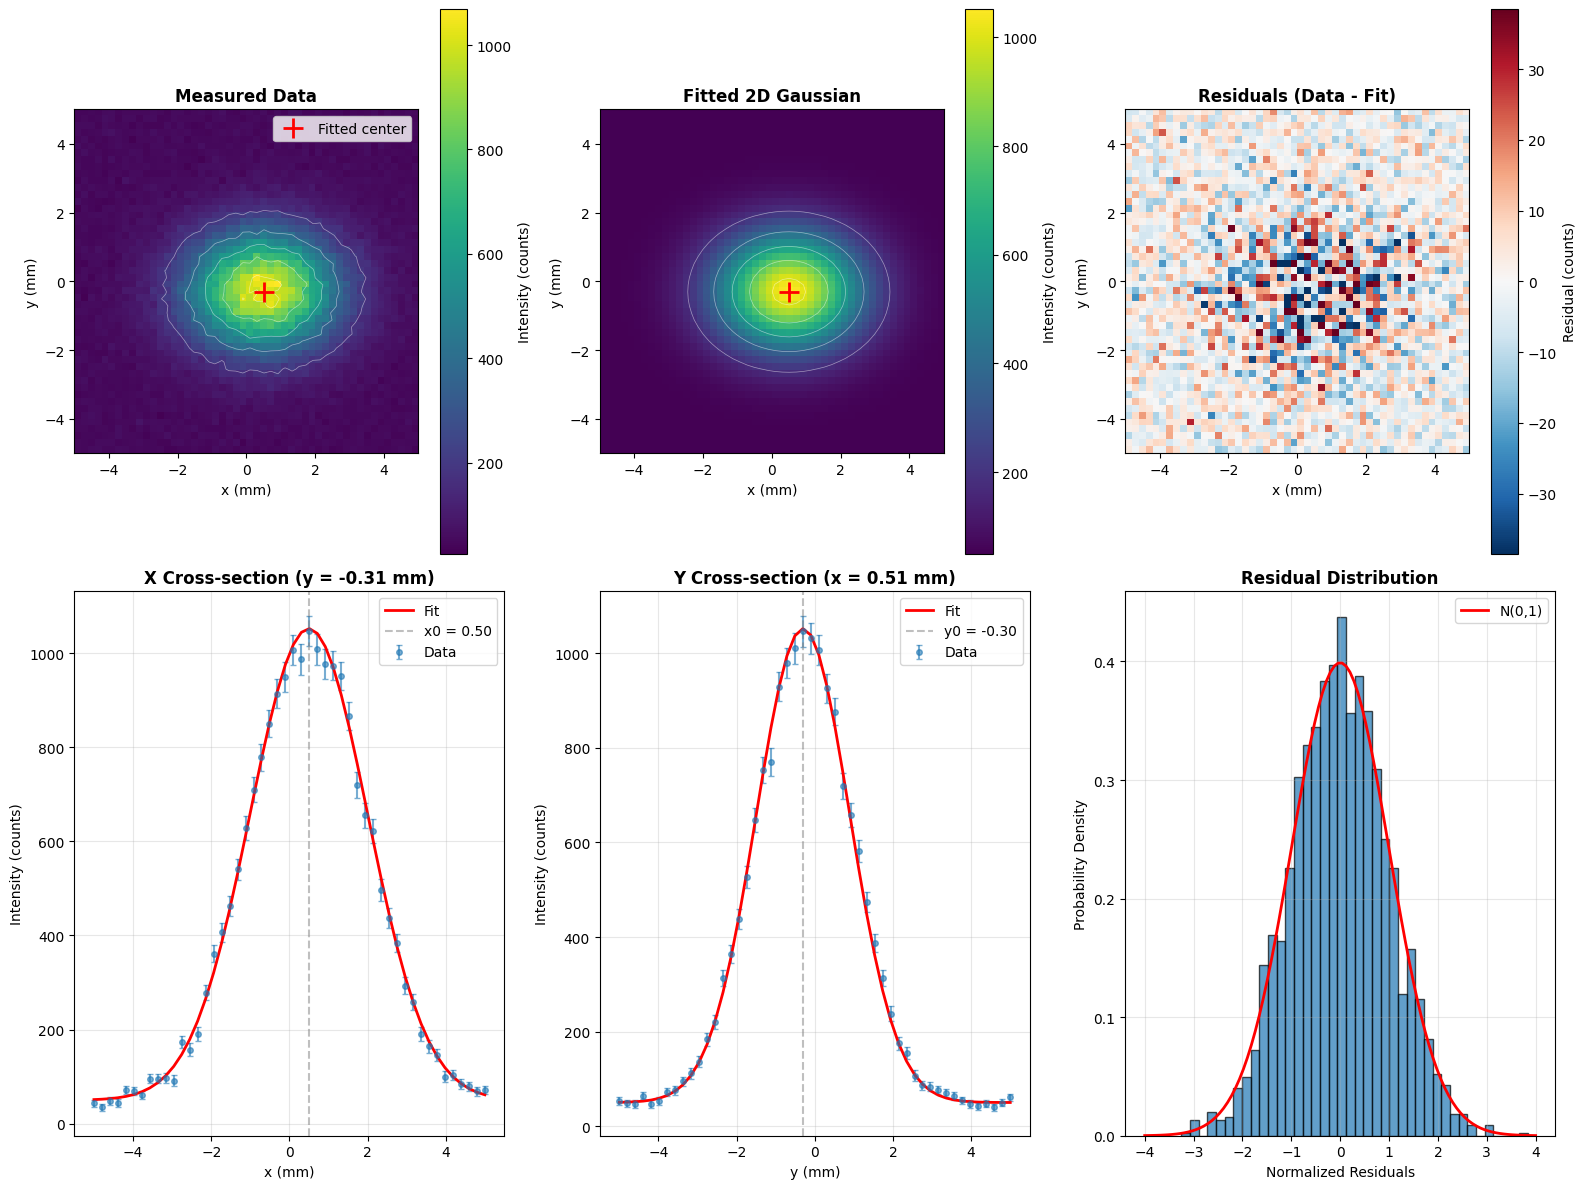


✅ Comprehensive visualization created


In [9]:
fig = plt.figure(figsize=(16, 12))

# Get actual grid dimensions from arrays (handles quick mode)
nx_actual = len(x_1d)
ny_actual = len(y_1d)

# Reshape for 2D plotting
Z_measured = z_measured.reshape(ny_actual, nx_actual)
Z_fit = z_fit.reshape(ny_actual, nx_actual)
Z_residuals = residuals.reshape(ny_actual, nx_actual)

# Plot 1: Measured data (2D image)
ax1 = fig.add_subplot(2, 3, 1)
im1 = ax1.imshow(
    Z_measured,
    extent=[x_1d.min(), x_1d.max(), y_1d.min(), y_1d.max()],
    origin="lower",
    cmap="viridis",
    aspect="equal",
)
ax1.contour(X, Y, Z_measured, levels=5, colors="white", alpha=0.5, linewidths=0.5)
ax1.plot(x0_fit, y0_fit, "r+", markersize=15, markeredgewidth=2, label="Fitted center")
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")
ax1.set_title("Measured Data", fontweight="bold")
ax1.legend(loc="upper right")
plt.colorbar(im1, ax=ax1, label="Intensity (counts)")

# Plot 2: Fitted surface
ax2 = fig.add_subplot(2, 3, 2)
im2 = ax2.imshow(
    Z_fit,
    extent=[x_1d.min(), x_1d.max(), y_1d.min(), y_1d.max()],
    origin="lower",
    cmap="viridis",
    aspect="equal",
)
ax2.contour(X, Y, Z_fit, levels=5, colors="white", alpha=0.5, linewidths=0.5)
ax2.plot(x0_fit, y0_fit, "r+", markersize=15, markeredgewidth=2)
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")
ax2.set_title("Fitted 2D Gaussian", fontweight="bold")
plt.colorbar(im2, ax=ax2, label="Intensity (counts)")

# Plot 3: Residuals
ax3 = fig.add_subplot(2, 3, 3)
im3 = ax3.imshow(
    Z_residuals,
    extent=[x_1d.min(), x_1d.max(), y_1d.min(), y_1d.max()],
    origin="lower",
    cmap="RdBu_r",
    aspect="equal",
    vmin=-3 * np.std(residuals),
    vmax=3 * np.std(residuals),
)
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("y (mm)")
ax3.set_title("Residuals (Data - Fit)", fontweight="bold")
plt.colorbar(im3, ax=ax3, label="Residual (counts)")

# Plot 4: X cross-section through center
ax4 = fig.add_subplot(2, 3, 4)
y_idx = np.argmin(np.abs(y_1d - y0_fit))
ax4.errorbar(
    x_1d,
    Z_measured[y_idx, :],
    yerr=sigma.reshape(ny_actual, nx_actual)[y_idx, :],
    fmt="o",
    alpha=0.6,
    label="Data",
    capsize=2,
    markersize=4,
)
ax4.plot(x_1d, Z_fit[y_idx, :], "r-", linewidth=2, label="Fit")
ax4.axvline(x0_fit, color="gray", linestyle="--", alpha=0.5, label=f"x0 = {x0_fit:.2f}")
ax4.set_xlabel("x (mm)")
ax4.set_ylabel("Intensity (counts)")
ax4.set_title(f"X Cross-section (y = {y_1d[y_idx]:.2f} mm)", fontweight="bold")
ax4.legend()
ax4.grid(True, alpha=0.3)

# Plot 5: Y cross-section through center
ax5 = fig.add_subplot(2, 3, 5)
x_idx = np.argmin(np.abs(x_1d - x0_fit))
ax5.errorbar(
    y_1d,
    Z_measured[:, x_idx],
    yerr=sigma.reshape(ny_actual, nx_actual)[:, x_idx],
    fmt="o",
    alpha=0.6,
    label="Data",
    capsize=2,
    markersize=4,
)
ax5.plot(y_1d, Z_fit[:, x_idx], "r-", linewidth=2, label="Fit")
ax5.axvline(y0_fit, color="gray", linestyle="--", alpha=0.5, label=f"y0 = {y0_fit:.2f}")
ax5.set_xlabel("y (mm)")
ax5.set_ylabel("Intensity (counts)")
ax5.set_title(f"Y Cross-section (x = {x_1d[x_idx]:.2f} mm)", fontweight="bold")
ax5.legend()
ax5.grid(True, alpha=0.3)

# Plot 6: Residual histogram
ax6 = fig.add_subplot(2, 3, 6)
norm_residuals = residuals / sigma
# Pre-compute bin edges to avoid patched np.linspace issues in quick mode
n_bins = min(40, max(5, len(norm_residuals) // 10))
hist_min, hist_max = float(np.min(norm_residuals)), float(np.max(norm_residuals))
bin_edges = np.array([hist_min + (hist_max - hist_min) * i / n_bins for i in range(n_bins + 1)])
ax6.hist(norm_residuals, bins=bin_edges, alpha=0.7, edgecolor="black", density=True)
# Overlay expected normal distribution (use fixed 100 points, not patched linspace)
x_norm = np.array([-4 + 8 * i / 99 for i in range(100)])
y_norm = np.exp(-(x_norm**2) / 2) / np.sqrt(2 * np.pi)
ax6.plot(x_norm, y_norm, "r-", linewidth=2, label="N(0,1)")
ax6.set_xlabel("Normalized Residuals")
ax6.set_ylabel("Probability Density")
ax6.set_title("Residual Distribution", fontweight="bold")
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Comprehensive visualization created")

## 🔑 Key Physical Insights

From the fitted parameters, we've learned:

1. **Beam center position:** The fitted center accurately locates the beam within the measurement field
   - Useful for alignment verification and beam steering feedback

2. **Beam ellipticity:** σ_x ≠ σ_y indicates an elliptical beam profile
   - Common in laser systems with astigmatism or cylindrical optics
   - Ellipticity > 1 means beam is wider in x than y direction

3. **FWHM values:** Standard specification for beam width
   - FWHM = 2.355 × σ is the width at half the peak intensity
   - Often used in beam profiling standards (ISO 11146)

4. **Background offset:** Non-zero offset indicates dark current or stray light
   - Important for accurate intensity measurements

---

## ⚠️ Domain-Specific Considerations

**Data format for 2D fitting:**
- `xdata` must have shape `(2, n_points)` where:
  - `xdata[0]` = flattened x coordinates
  - `xdata[1]` = flattened y coordinates
- `ydata` must have shape `(n_points,)` with z values
- Use `np.meshgrid()` and `flatten()` to prepare grid data

**Common issues in 2D fitting:**

1. **Saturation:** If detector saturates, fitted amplitude will be wrong
   - **Symptom:** Flat-topped profile, poor residuals at center
   - **Solution:** Reduce exposure or use attenuator

2. **Rotation:** Beam may be rotated relative to x/y axes
   - **Symptom:** Residuals show systematic pattern
   - **Solution:** Use rotated 2D Gaussian model (see advanced example)

3. **Non-Gaussian profiles:** Real beams may be truncated or multi-mode
   - **Symptom:** Poor fit quality, structured residuals
   - **Solution:** Use super-Gaussian or multi-peak models

**Physical constraints:**
- **Amplitude > 0:** Intensity must be positive
- **σ_x, σ_y > 0:** Beam widths must be positive
- **Offset ≥ 0:** Background typically non-negative

---

## 📚 Related Techniques

**Similar 2D fitting problems:**
- [Advanced 2D Fitting](../../09_gallery_advanced/physics/surface_fitting_2d.ipynb) - Rotated Gaussians and multi-peak fitting
- [Spectroscopy Peaks](spectroscopy_peaks.ipynb) - 1D peak fitting (analogous 1D problem)

**Extensions and variants:**
- **Rotated 2D Gaussian:** Add rotation angle parameter for tilted beams
- **Multi-peak 2D:** Fit multiple overlapping sources
- **Super-Gaussian:** Use $\exp(-(r/w)^n)$ for flat-top beams

**From optics to other fields:**
- **Astronomy:** PSF fitting for photometry and astrometry
- **Microscopy:** PSF characterization for deconvolution
- **Materials science:** AFM/STM feature analysis

---

## 📖 References

**Literature:**
1. ISO 11146 (2021). *Lasers and laser-related equipment — Test methods for laser beam widths, divergence angles and beam propagation ratios*.
2. Siegman, A.E. (1986). *Lasers*. University Science Books. Chapter 17: Gaussian Beams.
3. Zhang, B. (2003). "A simple method for measuring M² factor of Gaussian beam profiles." *Optical Engineering* 42(7), 1949.

**Theoretical background:**
- [Gaussian Beam](https://en.wikipedia.org/wiki/Gaussian_beam) - Wikipedia overview
- [Point Spread Function](https://en.wikipedia.org/wiki/Point_spread_function) - PSF in imaging systems

**NLSQ resources:**
- [NLSQ API Documentation](https://nlsq.readthedocs.io/en/latest/api.html)
- [Quickstart Guide](../../01_getting_started/nlsq_quickstart.ipynb)
- [Gallery - More Physics Examples](../)

---

## ❓ Domain-Specific Questions

**Q: How do I handle rotated beam profiles?**

A: Use a rotated 2D Gaussian model that includes rotation angle θ:

```python
def gaussian_2d_rotated(xy, amp, x0, y0, sigma_x, sigma_y, theta, offset):
    x, y = xy[0], xy[1]
    # Rotate coordinates
    xr = (x - x0) * jnp.cos(theta) + (y - y0) * jnp.sin(theta)
    yr = -(x - x0) * jnp.sin(theta) + (y - y0) * jnp.cos(theta)
    return amp * jnp.exp(-(xr**2/(2*sigma_x**2) + yr**2/(2*sigma_y**2))) + offset
```

See the [advanced 2D fitting example](../../09_gallery_advanced/physics/surface_fitting_2d.ipynb) for details.

**Q: My fit doesn't converge. What should I check?**

A: Common issues:
1. **Bad initial guess:** Start with amplitude = max - min, center at image center
2. **Wrong bounds:** Ensure bounds allow the true solution
3. **Data quality:** Check for NaN/Inf values, saturation, or very low SNR

**Q: How do I fit multiple peaks?**

A: Define a model that sums multiple Gaussians:

```python
def double_gaussian_2d(xy, amp1, x01, y01, sigma1, amp2, x02, y02, sigma2, offset):
    peak1 = amp1 * jnp.exp(-((x-x01)**2 + (y-y01)**2)/(2*sigma1**2))
    peak2 = amp2 * jnp.exp(-((x-x02)**2 + (y-y02)**2)/(2*sigma2**2))
    return peak1 + peak2 + offset
```

Use global optimization (`preset='global'`) for multi-peak fits.

---

## 📚 Glossary

**FWHM (Full Width at Half Maximum):** Width of the beam profile at 50% of peak intensity. FWHM = 2.355 × σ for Gaussian profiles.

**Beam waist (w):** Radius at which intensity drops to 1/e² of peak. Related to σ by w = √2 × σ.

**Ellipticity:** Ratio of beam widths in orthogonal directions (σ_x/σ_y). Value of 1.0 indicates circular beam.

**M² factor:** Beam quality parameter comparing real beam to ideal Gaussian. M² = 1 is perfect Gaussian.

**PSF (Point Spread Function):** Response of imaging system to point source. Often approximated as 2D Gaussian.

**Dark counts:** Background signal from detector even without illumination.

**Poisson noise:** Shot noise from discrete photon counting. Variance equals mean signal.

[Complete glossary](../../docs/glossary.md)

## 📋 Summary

This example demonstrated:

✓ **2D surface fitting** with NLSQ using multi-dimensional xdata

✓ **Data format:** xdata shape (2, n_points), ydata shape (n_points,)

✓ **Elliptical Gaussian beam profile** analysis

✓ **Derived quantities:** FWHM, beam area, ellipticity

✓ **Cross-sectional visualization** of 2D fits

✓ **Weighted fitting** with 2D uncertainty arrays

**Key takeaway:** 2D surface fitting extends curve fitting to image data. The same NLSQ API works for multi-dimensional independent variables by reshaping data appropriately.

---

**Continue learning:**
- [Advanced 2D Fitting](../../09_gallery_advanced/physics/surface_fitting_2d.ipynb) - Rotated Gaussians and multi-peak
- [Spectroscopy Peaks](spectroscopy_peaks.ipynb) - 1D peak fitting
- [Damped Oscillation](damped_oscillation.ipynb) - Time-series fitting